# kNN Continent Classifier

### Introduction

In this analysis, I will be creating a *k*-nearest neighbors (kNN) classifier to predict the continent of any location based solely on its geographical coordinates. To do this, two underlying data sets are used: the first contains the coordinates of thousands of cities around the world and the country those cities belong to, and the second contains the countries of the world and the continent those countries belong to. Joining these two datasets yields a further dataset that effectively maps each set of coordinates to a continent. This is the dataset the model is trained on. Tuning of the *k* parameter is achieved using cross-validation in the train set, with the resulting model evaluated on the test set and then applied to an example (in this case, predicting the continent of Alert, Nunavut).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score

### Importing and preparing the cities dataset

In [2]:
cities = pd.read_csv('../data/cities.csv', sep=';')
cities

,Geoname ID,Name,ASCII Name,Alternate Names,Feature Class,Feature Code,Country Code,Country name EN,Country Code 2,Admin1 Code,Admin2 Code,Admin3 Code,Admin4 Code,Population,Elevation,DIgital Elevation Model,Timezone,Modification date,LABEL EN,Coordinates
0,652629,Kisko,Kisko,NaN,P,PPLA3,FI,Finland,NaN,02,022,734,NaN,1958,NaN,74,Europe/Helsinki,2014-09-25,Finland,"60.23333,23.48333"
1,653758,Kaskinen,Kaskinen,"Kaske,Kaskinen,Kaskinena,Kaskoe,Kaskë,Kaskö,ka...",P,PPLA3,FI,Finland,NaN,15,153,231,NaN,1514,NaN,-9999,Europe/Helsinki,2014-09-25,Finland,"62.38444,21.22331"
2,653852,Karstula,Karstula,"Karstula,Карстула",P,PPLA3,FI,Finland,NaN,13,138,226,NaN,4718,NaN,151,Europe/Helsinki,2014-09-25,Finland,"62.86667,24.78333"
3,654440,Kangasala,Kangasala,"Kangasala,Kangasala vald,kan jia sa la,knasala...",P,PPLA3,FI,Finland,NaN,06,064,211,NaN,24291,NaN,100,Europe/Helsinki,2014-09-25,Finland,"61.46383,24.07602"
4,656083,Jämsä,Jaemsae,"Jaemsae,Jamsa,Jamsja,Jemse,Jjamsja,Jämsä,KEV,Y...",P,PPLA3,FI,Finland,NaN,13,134,182,NaN,15261,NaN,83,Europe/Helsinki,2019-09-05,Finland,"61.8642,25.19002"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140630,499535,Sadovoye,Sadovoye,"Sadovoe,Sadovoje,Sadovoye,Sadowoje,Садовое",P,PPL,RU,Russian Federation,NaN,24,NaN,NaN,NaN,6333,NaN,33,Europe/Moscow,2012-01-17,Russian Federation,"47.7772,44.5208"
140631,503682,Putyatino,Putyatino,"Putjanino,Putjatino,Putyatino,Путянино,Путятино",P,PPL,RU,Russian Federation,NaN,62,NaN,NaN,NaN,3044,NaN,128,Europe/Moscow,2019-08-31,Russian Federation,"54.15998,41.1169"
140632,504576,Protvino,Protvino,"Protvino,Protwino,brwtfynw,prwtwynw,pu luo te ...",P,PPL,RU,Russian Federation,NaN,47,NaN,NaN,NaN,37329,NaN,134,Europe/Moscow,2012-02-28,Russian Federation,"54.86821,37.21583"
140633,505256,Primorka,Primorka,"Kosa Kuryacha,Primorka,Primorskoye,Приморка",P,PPL,RU,Russian Federation,NaN,61,NaN,NaN,NaN,3780,NaN,24,Europe/Moscow,2012-01-17,Russian Federation,"47.28395,39.06408"


In [3]:
# Splitting coordinates column into separate latitude and longitude columns, to join with
# the broader dataframe in the next cell

lat_long_df = cities['Coordinates'].str.split(',', expand=True).rename({0: 'Latitude', 
                                                                           1: 'Longitude'}, axis=1)
lat_long_df

,Latitude,Longitude
0,60.23333,23.48333
1,62.38444,21.22331
2,62.86667,24.78333
3,61.46383,24.07602
4,61.8642,25.19002
...,...,...
140630,47.7772,44.5208
140631,54.15998,41.1169
140632,54.86821,37.21583
140633,47.28395,39.06408


In [4]:
cities = pd.concat([cities, lat_long_df], axis=1)
cities

,Geoname ID,Name,ASCII Name,Alternate Names,Feature Class,Feature Code,Country Code,Country name EN,Country Code 2,Admin1 Code,...,Admin4 Code,Population,Elevation,DIgital Elevation Model,Timezone,Modification date,LABEL EN,Coordinates,Latitude,Longitude
0,652629,Kisko,Kisko,NaN,P,PPLA3,FI,Finland,NaN,02,...,NaN,1958,NaN,74,Europe/Helsinki,2014-09-25,Finland,"60.23333,23.48333",60.23333,23.48333
1,653758,Kaskinen,Kaskinen,"Kaske,Kaskinen,Kaskinena,Kaskoe,Kaskë,Kaskö,ka...",P,PPLA3,FI,Finland,NaN,15,...,NaN,1514,NaN,-9999,Europe/Helsinki,2014-09-25,Finland,"62.38444,21.22331",62.38444,21.22331
2,653852,Karstula,Karstula,"Karstula,Карстула",P,PPLA3,FI,Finland,NaN,13,...,NaN,4718,NaN,151,Europe/Helsinki,2014-09-25,Finland,"62.86667,24.78333",62.86667,24.78333
3,654440,Kangasala,Kangasala,"Kangasala,Kangasala vald,kan jia sa la,knasala...",P,PPLA3,FI,Finland,NaN,06,...,NaN,24291,NaN,100,Europe/Helsinki,2014-09-25,Finland,"61.46383,24.07602",61.46383,24.07602
4,656083,Jämsä,Jaemsae,"Jaemsae,Jamsa,Jamsja,Jemse,Jjamsja,Jämsä,KEV,Y...",P,PPLA3,FI,Finland,NaN,13,...,NaN,15261,NaN,83,Europe/Helsinki,2019-09-05,Finland,"61.8642,25.19002",61.8642,25.19002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140630,499535,Sadovoye,Sadovoye,"Sadovoe,Sadovoje,Sadovoye,Sadowoje,Садовое",P,PPL,RU,Russian Federation,NaN,24,...,NaN,6333,NaN,33,Europe/Moscow,2012-01-17,Russian Federation,"47.7772,44.5208",47.7772,44.5208
140631,503682,Putyatino,Putyatino,"Putjanino,Putjatino,Putyatino,Путянино,Путятино",P,PPL,RU,Russian Federation,NaN,62,...,NaN,3044,NaN,128,Europe/Moscow,2019-08-31,Russian Federation,"54.15998,41.1169",54.15998,41.1169
140632,504576,Protvino,Protvino,"Protvino,Protwino,brwtfynw,prwtwynw,pu luo te ...",P,PPL,RU,Russian Federation,NaN,47,...,NaN,37329,NaN,134,Europe/Moscow,2012-02-28,Russian Federation,"54.86821,37.21583",54.86821,37.21583
140633,505256,Primorka,Primorka,"Kosa Kuryacha,Primorka,Primorskoye,Приморка",P,PPL,RU,Russian Federation,NaN,61,...,NaN,3780,NaN,24,Europe/Moscow,2012-01-17,Russian Federation,"47.28395,39.06408",47.28395,39.06408


In [5]:
# Creating a new dataframe with just the columns of interest
cities_w_coords = cities[['ASCII Name', 'Country name EN', 'Latitude', 'Longitude']].copy()

# Casting latitude/longitude columns to float dtype
cities_w_coords['Latitude'] = pd.to_numeric(cities_w_coords['Latitude'])
cities_w_coords['Longitude'] = pd.to_numeric(cities_w_coords['Longitude'])

cities_w_coords

,ASCII Name,Country name EN,Latitude,Longitude
0,Kisko,Finland,60.23333,23.48333
1,Kaskinen,Finland,62.38444,21.22331
2,Karstula,Finland,62.86667,24.78333
3,Kangasala,Finland,61.46383,24.07602
4,Jaemsae,Finland,61.86420,25.19002
...,...,...,...,...
140630,Sadovoye,Russian Federation,47.77720,44.52080
140631,Putyatino,Russian Federation,54.15998,41.11690
140632,Protvino,Russian Federation,54.86821,37.21583
140633,Primorka,Russian Federation,47.28395,39.06408


In [6]:
cities_w_coords.isna().sum(axis=0)

ASCII Name           1
Country name EN    168
Latitude             0
Longitude            0
dtype: int64

In [7]:
cities_w_coords[cities_w_coords['Country name EN'].isna()]

,ASCII Name,Country name EN,Latitude,Longitude
5,Polowat,NaN,7.35661,149.19908
6,Elato,NaN,7.50200,146.16600
1584,Barber,NaN,12.29014,-69.07389
2000,Lumparland,NaN,60.11695,20.25819
2001,Koekar,NaN,59.92051,20.90883
...,...,...,...,...
136083,Moch,NaN,5.49180,153.54000
136084,Sorol,NaN,8.14350,140.39400
136085,Tonoas Municipal Building,NaN,7.37597,151.88433
139216,Chirongui,NaN,-12.93194,45.14833


The one entry without a city name won't be dropped, but all those without a country name (168 in total) will indeed be dropped, since it will not be possible to map their coordinates to a continent in the upcoming join.

In [8]:
cities_w_coords = cities_w_coords.dropna(subset=['Country name EN']).copy()
cities_w_coords

,ASCII Name,Country name EN,Latitude,Longitude
0,Kisko,Finland,60.23333,23.48333
1,Kaskinen,Finland,62.38444,21.22331
2,Karstula,Finland,62.86667,24.78333
3,Kangasala,Finland,61.46383,24.07602
4,Jaemsae,Finland,61.86420,25.19002
...,...,...,...,...
140630,Sadovoye,Russian Federation,47.77720,44.52080
140631,Putyatino,Russian Federation,54.15998,41.11690
140632,Protvino,Russian Federation,54.86821,37.21583
140633,Primorka,Russian Federation,47.28395,39.06408


### Importing and preparing the country-continent dataset

In [9]:
country_continent = pd.read_csv('../data/country_continent.csv')
country_continent

,Entity,Code,Year,Continent
0,Abkhazia,OWID_ABK,2015,Asia
1,Afghanistan,AFG,2015,Asia
2,Akrotiri and Dhekelia,OWID_AKD,2015,Asia
3,Albania,ALB,2015,Europe
4,Algeria,DZA,2015,Africa
...,...,...,...,...
280,Yugoslavia,OWID_YGS,2015,Europe
281,Zambia,ZMB,2015,Africa
282,Zanzibar,OWID_ZAN,2015,Africa
283,Zimbabwe,ZWE,2015,Africa


The country names above don't match up with those in cities_w_coords. Therefore, I'll be adjusting those in cities_w_coords so that they perfectly align with those above; this will allow the upcoming join to run smoothly.

In [10]:
countries_in_cities_w_coords_df = sorted(list(cities_w_coords['Country name EN'].value_counts().index))
countries_in_country_continent_df = sorted(list(country_continent['Entity'].value_counts().index))

len(countries_in_cities_w_coords_df), len(countries_in_country_continent_df)

(229, 285)

In [11]:
# These are the country names in cities_w_coords that will have to be adjusted

for country in countries_in_cities_w_coords_df:
    if country not in countries_in_country_continent_df:
        print(country)

Brunei Darussalam
Congo, Democratic Republic of the
Czech Republic
Côte d'Ivoire
Falkland Islands (Malvinas)
Hong Kong, China
Iran, Islamic Rep. of
Korea, Dem. People's Rep. of
Korea, Republic of
Lao People's Dem. Rep.
Libyan Arab Jamahiriya
Macau, China
Macedonia, The former Yugoslav Rep. of
Moldova, Republic of
Russian Federation
Réunion
South Sudan, The Republic of
Sudan, The Republic of
Swaziland
Syrian Arab Republic
Taiwan, China
Tanzania, United Republic of
Timor-Leste
Venezuela, Bolivarian Rep. of
Viet Nam
Virgin Islands (US)
Wallis and Futuna Islands
West Bank and Gaza Strip


In [12]:
# The countries above will have to be changed to their counterparts in this list
countries_in_country_continent_df

['Abkhazia',
 'Afghanistan',
 'Akrotiri and Dhekelia',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antarctica',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Austria-Hungary',
 'Azerbaijan',
 'Baden',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Bavaria',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bonaire Sint Eustatius and Saba',
 'Bosnia and Herzegovina',
 'Botswana',
 'Bouvet Island',
 'Brazil',
 'British Indian Ocean Territory',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Channel Islands',
 'Chile',
 'China',
 'Christmas Island',
 'Cocos Islands',
 'Colombia',
 'Comoros',
 'Congo',
 'Cook Islands',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czechia',
 'Czechoslovakia',
 'Democr

In [13]:
country_names_to_change = {'Brunei Darussalam': 'Brunei', 
                           'Congo, Democratic Republic of the': 'Democratic Republic of Congo', 
                           'Czech Republic': 'Czechia', 
                           "Côte d'Ivoire": "Cote d'Ivoire", 
                           'Falkland Islands (Malvinas)': 'Falkland Islands', 
                           'Hong Kong, China': 'Hong Kong', 
                           'Iran, Islamic Rep. of': 'Iran', 
                           "Korea, Dem. People's Rep. of": 'North Korea', 
                           'Korea, Republic of': 'South Korea', 
                           "Lao People's Dem. Rep.": 'Laos', 
                           'Libyan Arab Jamahiriya': 'Libya', 
                           'Macau, China': 'Macao', 
                           'Macedonia, The former Yugoslav Rep. of': 'North Macedonia', 
                           'Moldova, Republic of':  'Moldova', 
                           'Russian Federation': 'Russia', 
                           'Réunion': 'Reunion', 
                           'South Sudan, The Republic of': 'South Sudan', 
                           'Sudan, The Republic of': 'Sudan', 
                           'Swaziland': 'Eswatini', 
                           'Syrian Arab Republic': 'Syria', 
                           'Taiwan, China': 'Taiwan', 
                           'Tanzania, United Republic of': 'Tanzania', 
                           'Timor-Leste': 'Timor', 
                           'Venezuela, Bolivarian Rep. of': 'Venezuela', 
                           'Viet Nam': 'Vietnam', 
                           'Virgin Islands (US)': 'United States Virgin Islands', 
                           'Wallis and Futuna Islands': 'Wallis and Futuna', 
                           'West Bank and Gaza Strip': 'Palestine'}

In [14]:
cities_w_coords['Country name EN'] = cities_w_coords['Country name EN'].replace(country_names_to_change)

In [15]:
# Checking to make sure all countries in cities_w_coords now line up with 
# those in country_continent

countries_in_cities_w_coords_df = sorted(list(cities_w_coords['Country name EN'].value_counts().index))
countries_in_country_continent_df = sorted(list(country_continent['Entity'].value_counts().index))

for country in countries_in_cities_w_coords_df:
    if country not in countries_in_country_continent_df:
        print(country)
        
# No output - check has passed

### Merging cities_w_coords and country_continent

In [16]:
coords_to_continent_df = pd.merge(cities_w_coords, country_continent, 
                                  left_on='Country name EN', right_on='Entity', how='left')
coords_to_continent_df

,ASCII Name,Country name EN,Latitude,Longitude,Entity,Code,Year,Continent
0,Kisko,Finland,60.23333,23.48333,Finland,FIN,2015,Europe
1,Kaskinen,Finland,62.38444,21.22331,Finland,FIN,2015,Europe
2,Karstula,Finland,62.86667,24.78333,Finland,FIN,2015,Europe
3,Kangasala,Finland,61.46383,24.07602,Finland,FIN,2015,Europe
4,Jaemsae,Finland,61.86420,25.19002,Finland,FIN,2015,Europe
...,...,...,...,...,...,...,...,...
140462,Sadovoye,Russia,47.77720,44.52080,Russia,RUS,2015,Europe
140463,Putyatino,Russia,54.15998,41.11690,Russia,RUS,2015,Europe
140464,Protvino,Russia,54.86821,37.21583,Russia,RUS,2015,Europe
140465,Primorka,Russia,47.28395,39.06408,Russia,RUS,2015,Europe


### Building the kNN Classifier

In [17]:
# Grabbing just the columns we need for the model

coords_to_continent_df = coords_to_continent_df[['Longitude', 'Latitude', 'Continent']].copy()
coords_to_continent_df

,Longitude,Latitude,Continent
0,23.48333,60.23333,Europe
1,21.22331,62.38444,Europe
2,24.78333,62.86667,Europe
3,24.07602,61.46383,Europe
4,25.19002,61.86420,Europe
...,...,...,...
140462,44.52080,47.77720,Europe
140463,41.11690,54.15998,Europe
140464,37.21583,54.86821,Europe
140465,39.06408,47.28395,Europe


In [18]:
coords_to_continent_df.isna().sum(axis=0)

Longitude    0
Latitude     0
Continent    0
dtype: int64

In [19]:
coords_to_continent_df['Continent'].value_counts()

Europe           69245
North America    29765
Asia             25223
South America     6701
Africa            4895
Oceania           4638
Name: Continent, dtype: int64

The distribution of continents in the dataset is highly imbalanced. To account for this, I'll be using the "balanced accuracy" metric when evaluating the upcoming model instead of the simpler "accuracy" metric.

In [20]:
X = coords_to_continent_df.drop('Continent', axis=1).values
y = coords_to_continent_df['Continent'].values

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [22]:
fitted_minmaxscaler = MinMaxScaler().fit(X_train)
X_train_transformed = fitted_minmaxscaler.transform(X_train)

fitted_le = LabelEncoder().fit(y_train)
y_train_encoded = fitted_le.transform(y_train)

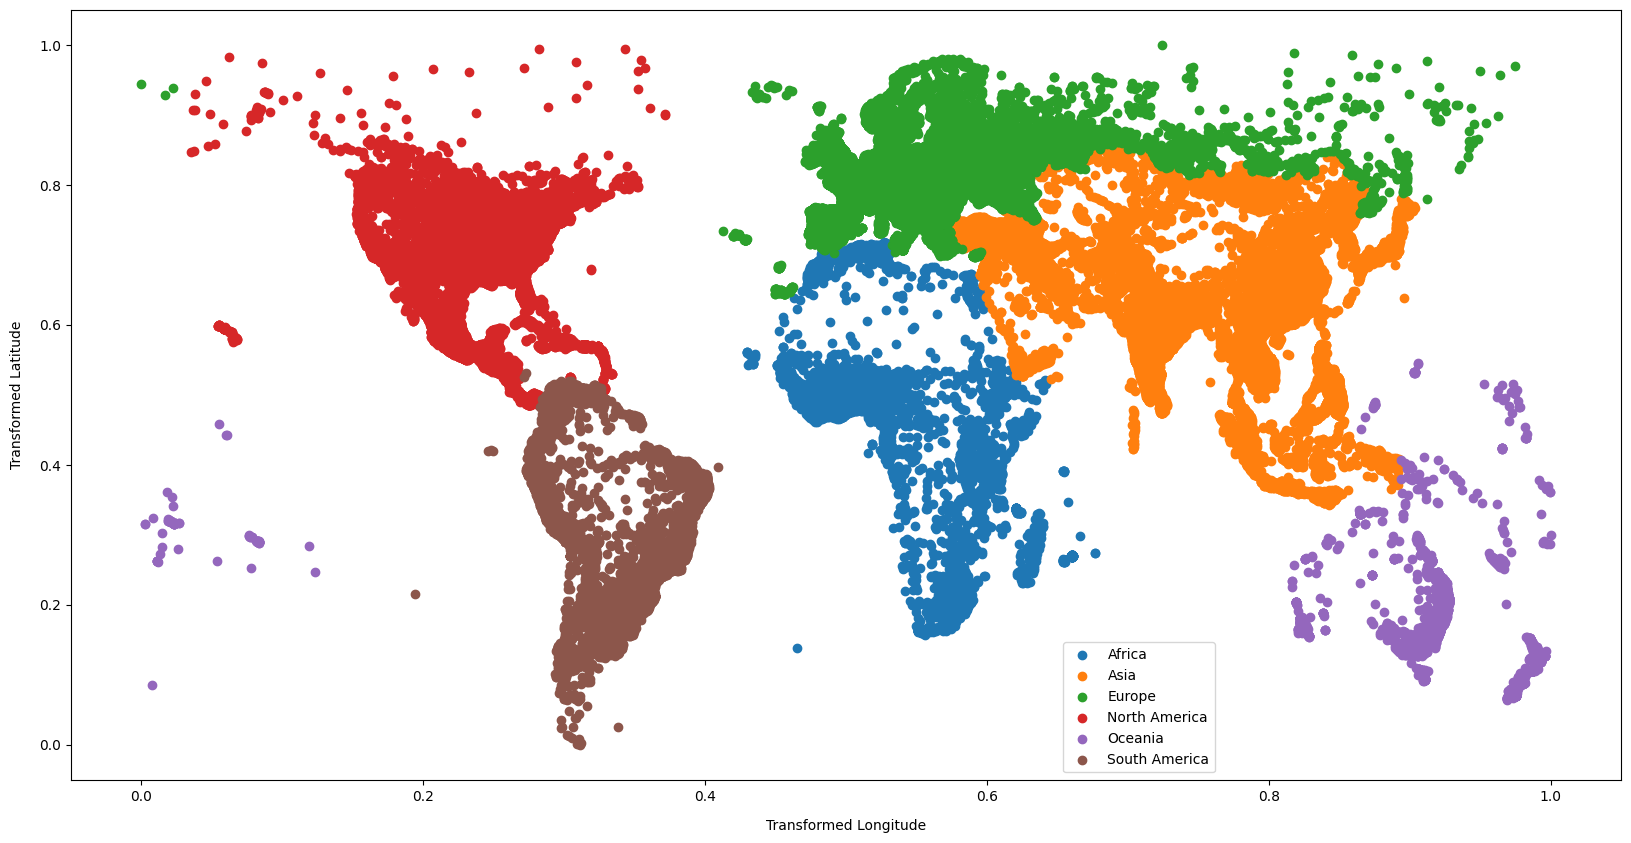

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))

for i in np.arange(0, 6):
    ax.scatter(X_train_transformed[y_train_encoded == i, 0], 
               X_train_transformed[y_train_encoded == i, 1], 
               label=fitted_le.classes_[i])

ax.set_xlabel('Transformed Longitude', labelpad=11)
ax.set_ylabel('Transformed Latitude', labelpad=11)
ax.legend(loc=(0.64, 0.01))
plt.show()

The above plot reveals an important consideration about the overall methodology used here: since coordinates are assigned to a continent based on the designated continent of their underlying country, and since every country -- even clearly multi-continental ones -- are designated as belonging to just a single continent, multi-continental countries will have a subset of their coordinates assigned to the wrong continent. Russia, for example, clearly extends into Asia, but all of its coordinates are assigned to Europe. When evaluating the accuracy of the model to come, it will therefore be important to keep in mind that accuracy metrics won't paint the whole picture, since even the underlying dataset isn't completely "accurate" by our standards. Also notable consideration made apparent by the graph above is that there are no instances of Antarctica in our underlying dataset; therefore, the model will be Antarctica-naive.)

In [24]:
# Constructing the k-nearest neighbors model and using cross-validation within 
# the train set to optimize the k parameter

k_values = [1, 3, 5, 11, 51, 101, 1001]
balanced_accuracy_scores = []

for k_value in k_values:
    knn = KNeighborsClassifier(n_neighbors=k_value)
    scores = cross_val_score(knn, X_train_transformed, y_train_encoded, 
                             cv=StratifiedKFold(n_splits=10, shuffle=False), 
                             scoring='balanced_accuracy')
    balanced_accuracy_scores.append(scores.mean())
    print(f'k={k_value}, Mean Balanced Accuracy: {scores.mean():.4f}')

k=1, Mean Balanced Accuracy: 0.9989
k=3, Mean Balanced Accuracy: 0.9988
k=5, Mean Balanced Accuracy: 0.9986
k=11, Mean Balanced Accuracy: 0.9980
k=51, Mean Balanced Accuracy: 0.9950
k=101, Mean Balanced Accuracy: 0.9908
k=1001, Mean Balanced Accuracy: 0.9514


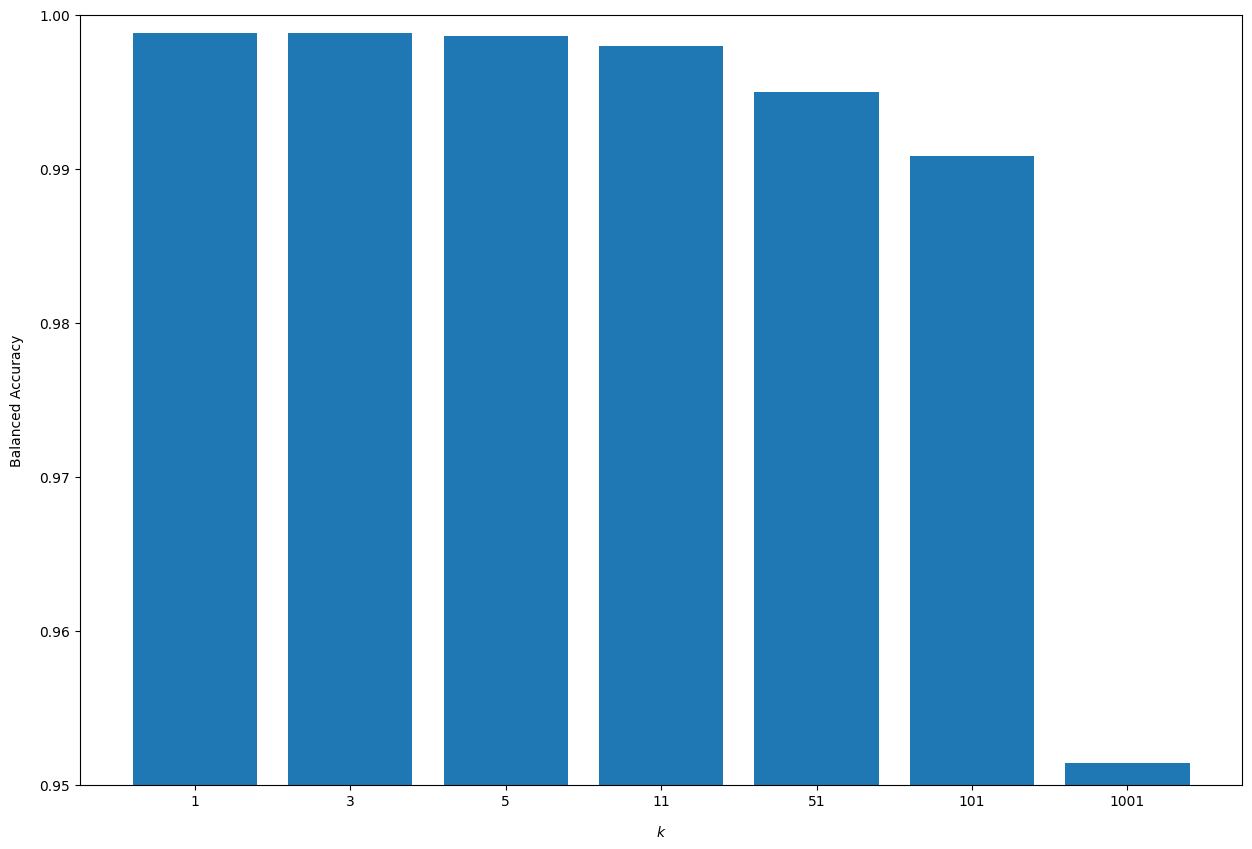

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(np.arange(len(balanced_accuracy_scores)), balanced_accuracy_scores)
ax.set_ylim(0.95, 1)
ax.set_xlabel('$k$', labelpad=11)
ax.set_xticks(np.arange(len(balanced_accuracy_scores)), labels=[str(i) for i in k_values])
ax.set_ylabel('Balanced Accuracy', labelpad=11)

plt.show()

A *k* value of 1 yields the highest balanced accuracy score, so this will be the value used in further evaluation and prediction.

In [26]:
# Evaluating the model on the test set

fitted_knn = KNeighborsClassifier(n_neighbors=1).fit(X_train_transformed, y_train_encoded)

X_test_transformed = fitted_minmaxscaler.transform(X_test)
y_hat = fitted_knn.predict(X_test_transformed)
y_test_encoded = fitted_le.transform(y_test)

print(f'Balanced Accuracy on test set: {balanced_accuracy_score(y_test_encoded, y_hat):.4f}')

Balanced Accuracy on test set: 0.9992


### Prediction Example

Now that we have a working model, we can obtain a prediction for any set of coordinates. Let's say we wanted to know the continent of [Alert, Nunavut](https://www.google.com/maps/place/Alert,+NU,+Canada)—a "city" that's entirely absent from our underlying dataset. Passing in its coordinates to our model, we can obtain just such a prediction.

In [27]:
def predict_continent(latitude, longitude, fitted_label_encoder, fitted_minmaxscaler, 
                      fitted_knn):
    """Predict a continent from a single set of coordinates."""
    X = np.array([[longitude, latitude]])
    X_transformed = fitted_minmaxscaler.transform(X)
    y_hat = fitted_knn.predict(X_transformed)
    predicted_continent = fitted_le.inverse_transform(y_hat)[0]
    return predicted_continent

In [28]:
# Coordinates of Alert, Nunavut (per Google Maps): 82.5058059°N, 62.4171067°W

latitude = 82.5058059
longitude = -62.4171067

In [29]:
predicted_continent = predict_continent(latitude, longitude, fitted_le, 
                                        fitted_minmaxscaler, fitted_knn)

print(f'Predicted continent: {predicted_continent}')

Predicted continent: North America


### Data Sources

Cities dataset: [GeoNames, via public.opendatasoft.com](https://public.opendatasoft.com/explore/dataset/geonames-all-cities-with-a-population-1000/table/?disjunctive.cou_name_en&sort=name)<br>

Country-continent dataset: [Our World in Data](https://ourworldindata.org/grapher/continents-according-to-our-world-in-data)

### Tools Used

NumPy, Pandas, Scikit-learn, Matplotlib